In [2]:
import pandas as pd
import os
import glob
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import imageio

uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c nfl-big-data-bowl-2024

100% 279M/279M [00:02<00:00, 148MB/s]
100% 279M/279M [00:02<00:00, 118MB/s]


In [5]:
!unzip nfl-big-data-bowl-2024.zip

Archive:  nfl-big-data-bowl-2024.zip
  inflating: games.csv               
  inflating: players.csv             
  inflating: plays.csv               
  inflating: tackles.csv             
  inflating: tracking_week_1.csv     
  inflating: tracking_week_2.csv     
  inflating: tracking_week_3.csv     
  inflating: tracking_week_4.csv     
  inflating: tracking_week_5.csv     
  inflating: tracking_week_6.csv     
  inflating: tracking_week_7.csv     
  inflating: tracking_week_8.csv     
  inflating: tracking_week_9.csv     


In [6]:
plays=pd.read_csv('plays.csv')
games=pd.read_csv('games.csv')
players=pd.read_csv('players.csv')

In [7]:
def height_to_inches(height_str):
    feet, inches = map(int, height_str.split("-"))
    total_inches = feet * 12 + inches
    return total_inches

players['heights_inches'] = players['height'].apply(height_to_inches)

In [8]:
players

,nflId,height,weight,birthDate,collegeName,position,displayName,heights_inches
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady,76
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters,76
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers,74
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis,78
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan,76
...,...,...,...,...,...,...,...,...
1678,55200,6-6,266,NaN,Indiana,DT,Ryder Anderson,78
1679,55212,6-0,230,NaN,Iowa State,ILB,Jake Hummel,72
1680,55239,6-2,300,NaN,Pennsylvania,DT,Prince Emili,74
1681,55240,6-1,185,NaN,Buffalo,CB,Ja'Marcus Ingram,73


In [18]:
import pymc as pm; import numpy as np; import arviz as az
X=players[['heights_inches']].values; y=players['weight'].values; n,p=len(y), X.shape[1]

with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p,1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal
    y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y.reshape(-1,1))

with MLR:
    idata = pm.sample()

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

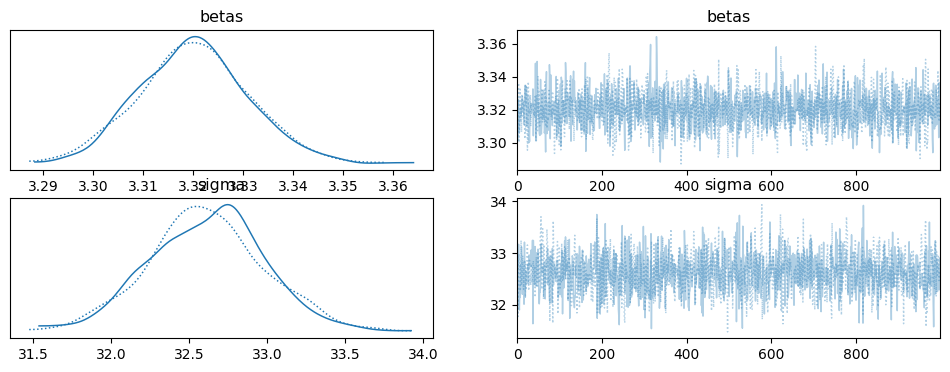

In [19]:
az.plot_trace(idata)

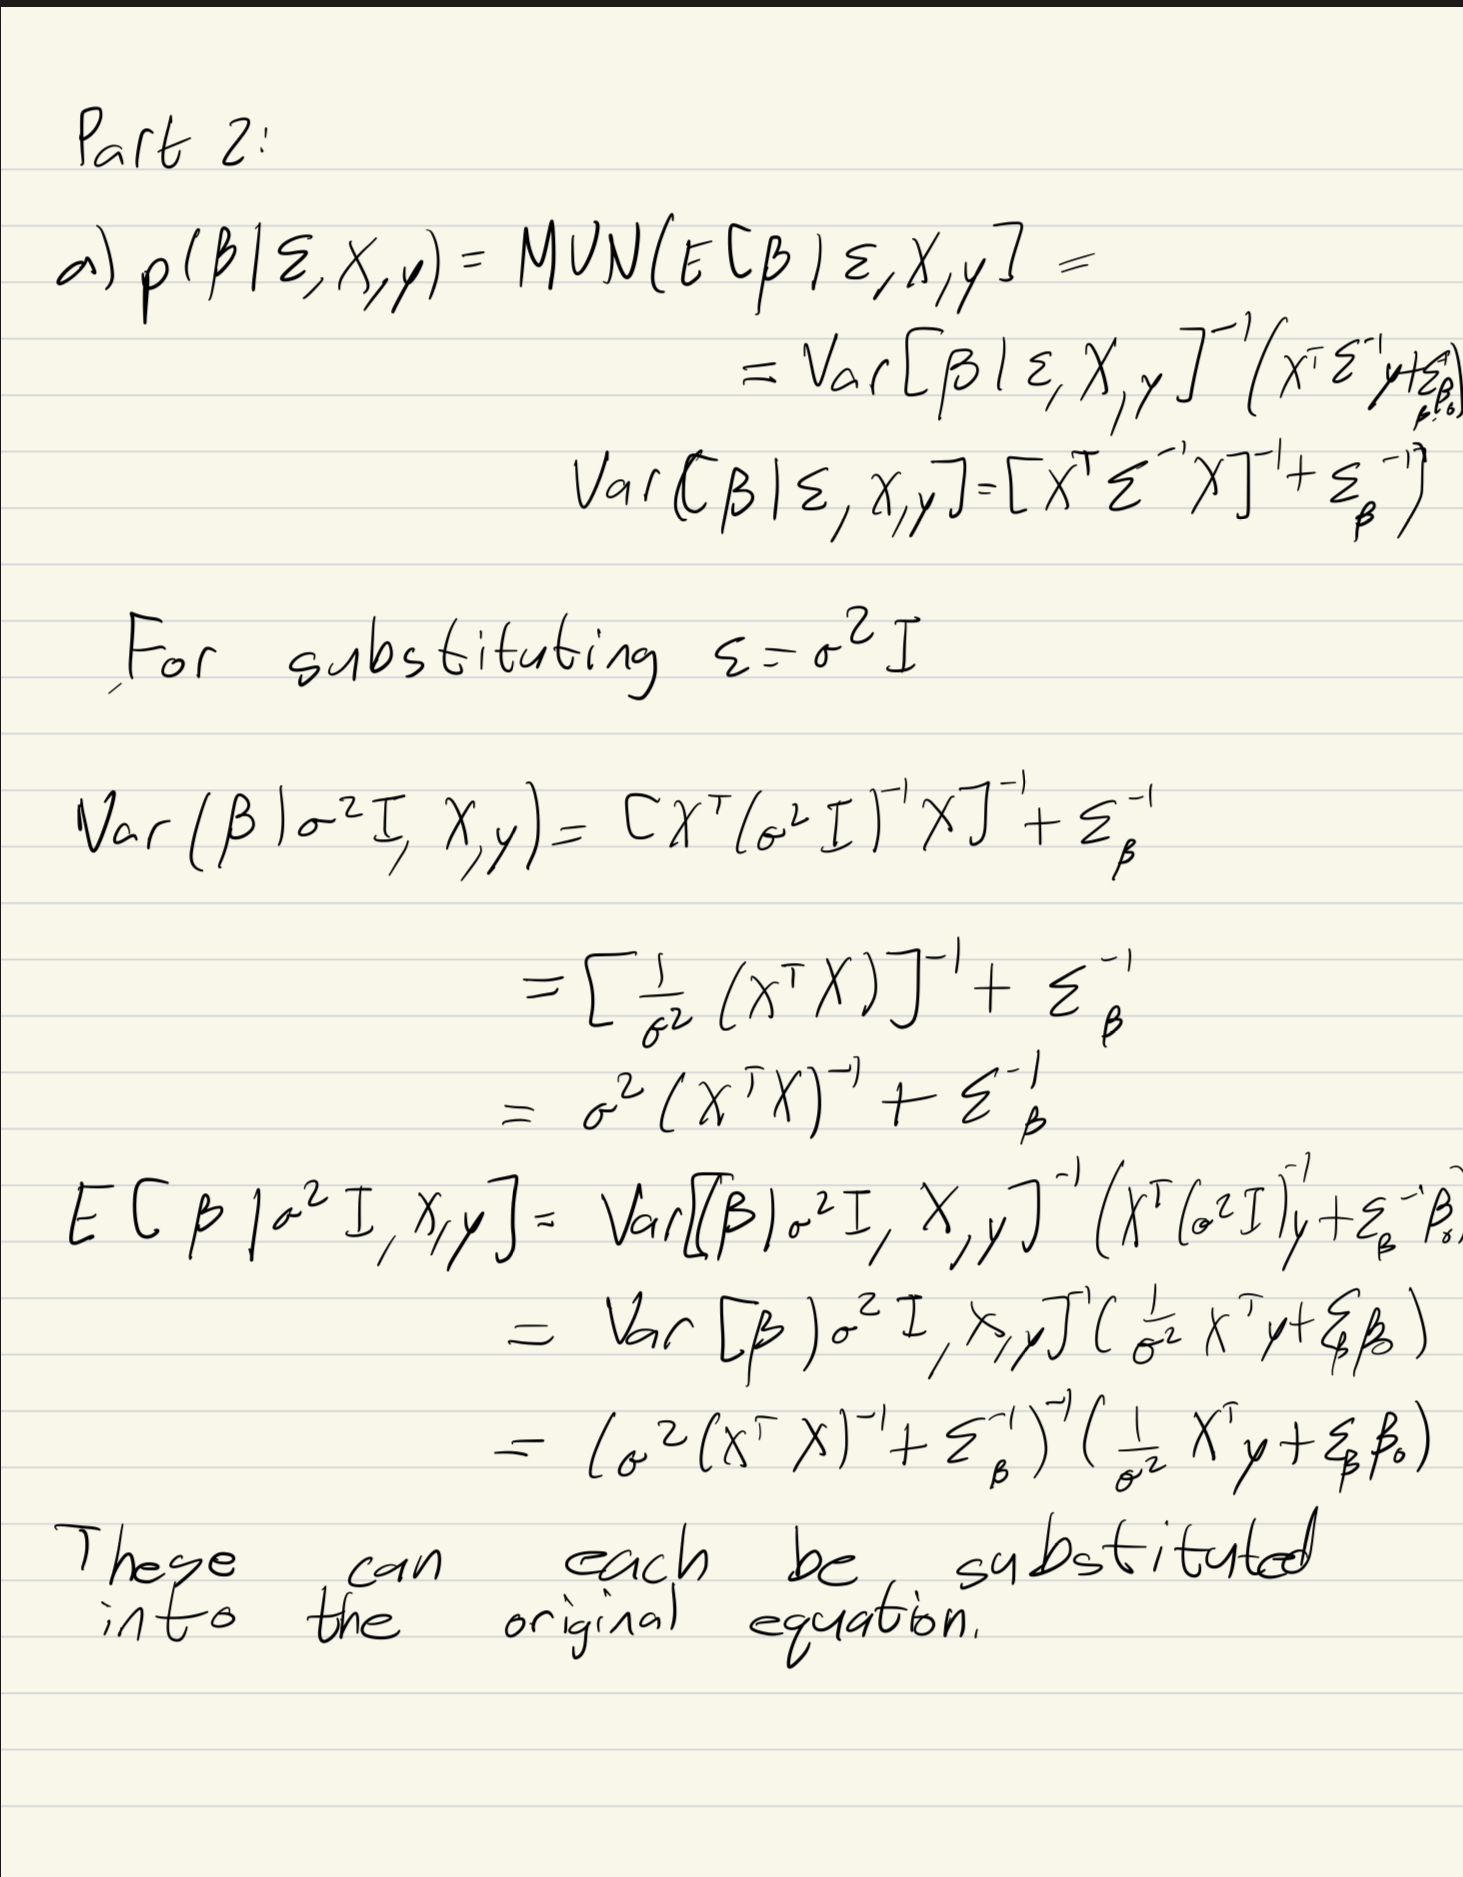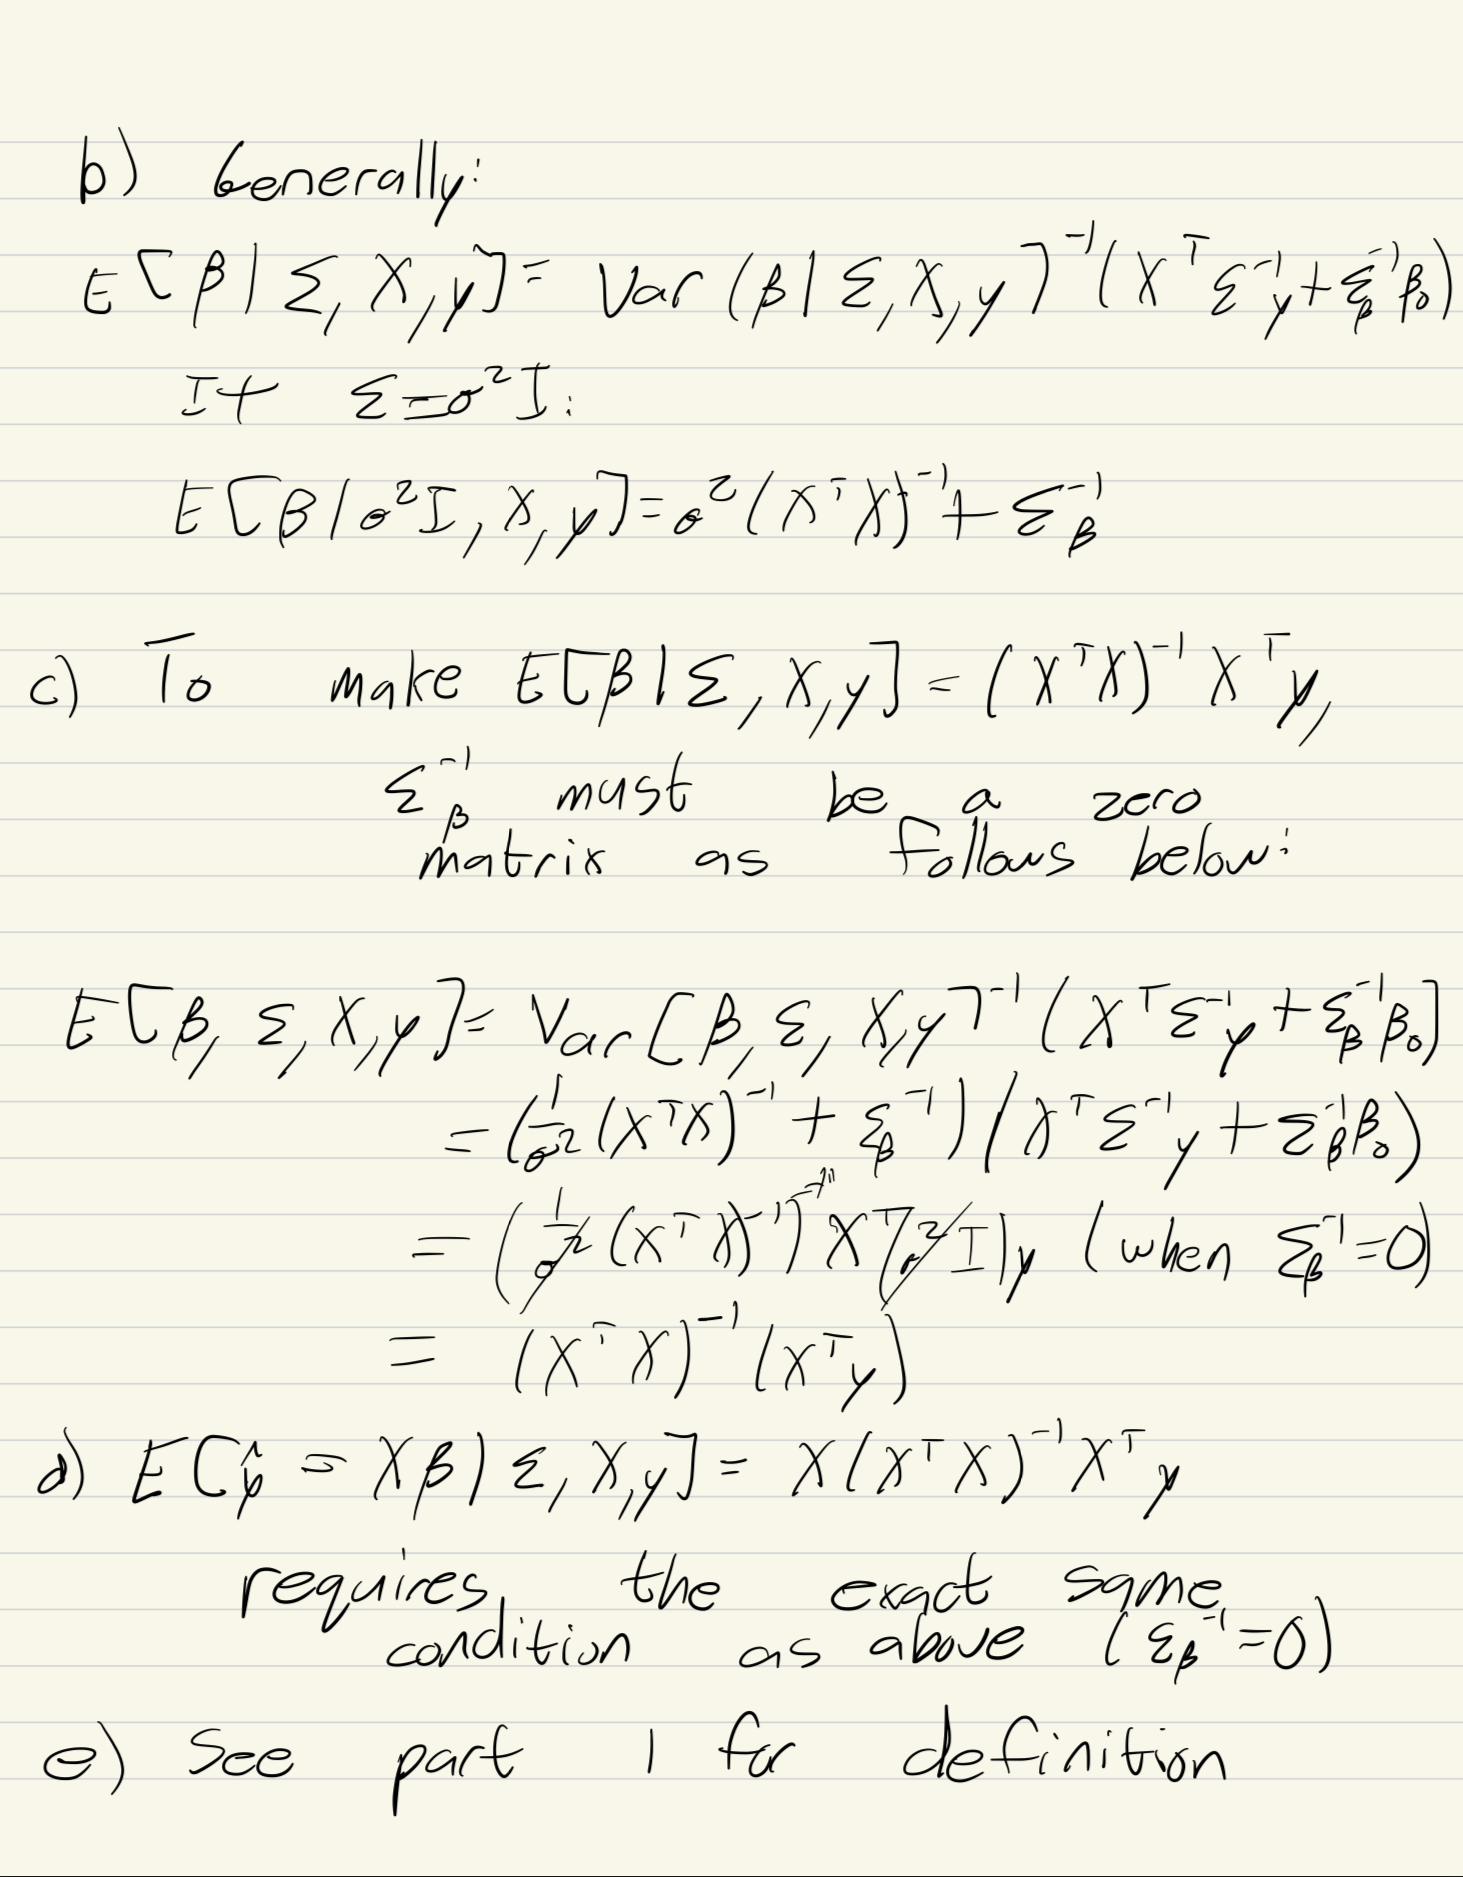

In [ ]:
X=players[['heights_inches', 'nflId']].values; y=players[['weight']].values
p = 2
n = len(y)

with pm.Model() as MVN_LKJ:
    # LKJ prior for the Cholesky decomposed covariance matrix
    packed_L = pm.LKJCholeskyCov('packed_L', n=p, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=False)
    L = pm.expand_packed_triangular(p, packed_L)
    # Reconstruct Covariance matrix with Cholesky factors
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    betas = pm.MvNormal('betas', mu=np.zeros(p), chol = L, shape=(p,1))
    # Mean specification
    mu = pm.math.dot(X, betas)
    # Likelihood of the observations
    y_obs = pm.MvNormal('y_obs', mu= mu, chol=L, observed=y)

with MVN_LKJ:
    idata = pm.sample()

/usr/local/lib/python3.10/dist-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
